<a href="https://colab.research.google.com/github/Avantika-08/Image-Generation-Using-GANs/blob/main/Image_Generation_Using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 75682746.35it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36095260.38it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22759375.38it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5550853.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


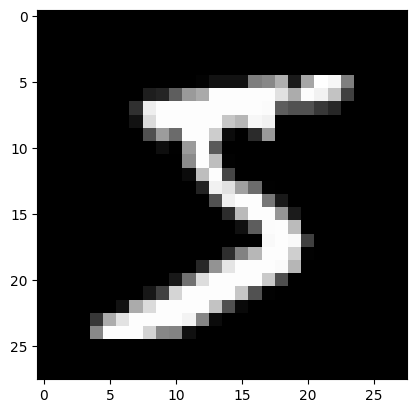

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([7, 1, 4, 3, 1, 3, 4, 0, 7, 1, 9, 7, 5, 7, 2, 5, 4, 2, 4, 6, 6, 8, 9, 2,
        3, 8, 1, 9, 3, 2, 2, 1, 7, 9, 6, 9, 6, 3, 8, 0, 8, 9, 3, 5, 8, 2, 4, 3,
        1, 3, 7, 5, 8, 6, 4, 2, 1, 0, 3, 2, 6, 3, 1, 6, 5, 8, 0, 0, 8, 7, 9, 2,
        5, 8, 4, 7, 5, 4, 1, 1, 9, 9, 5, 8, 0, 6, 0, 3, 8, 5, 9, 9, 9, 4, 2, 6,
        4, 6, 1, 5])


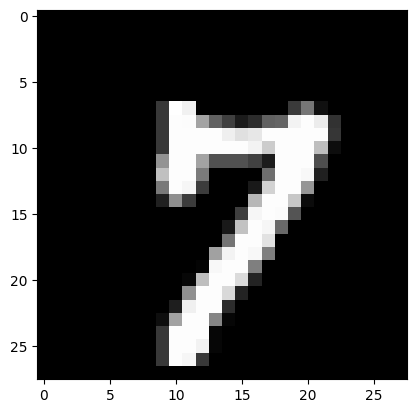

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

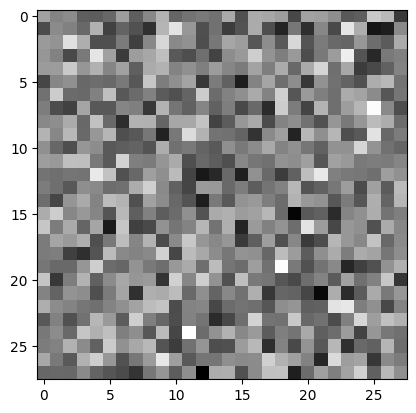

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

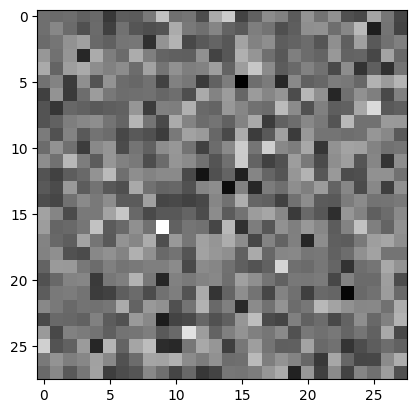

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

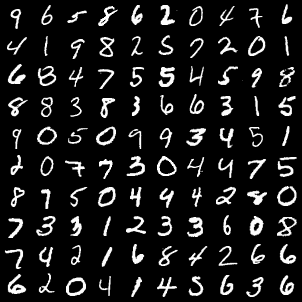

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


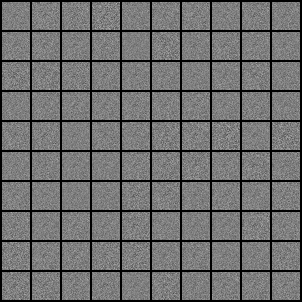

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, len(data_loader), d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

min_length = min(len(d_losses), len(g_losses), len(real_scores), len(fake_scores))

# Create a Pandas DataFrame with a subset of the lists
data = {
    'Epoch': list(range(1, min_length + 1)),
    'Discriminator Loss': d_losses[:min_length],
    'Generator Loss': g_losses[:min_length],
    'Real Scores': real_scores[:min_length],
    'Fake Scores': fake_scores[:min_length]
}
df_losses = pd.DataFrame(data)

# Display the table
print(df_losses)

# Save the table to a CSV file
df_losses.to_csv('losses_table.csv', index=False)

Epoch [0/300], Step [200/600], d_loss: 0.0496, g_loss: 4.0160, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0730, g_loss: 6.3128, D(x): 0.97, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0302, g_loss: 5.0856, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0629, g_loss: 5.2107, D(x): 0.97, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.2635, g_loss: 4.9138, D(x): 0.98, D(G(z)): 0.21
Epoch [1/300], Step [600/600], d_loss: 0.1006, g_loss: 5.3256, D(x): 0.95, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.4132, g_loss: 3.4187, D(x): 0.83, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.5325, g_loss: 4.1104, D(x): 0.81, D(G(z)): 0.12
Epoch [2/300], Step [600/600], d_loss: 0.6471, g_loss: 2.6386, D(x): 0.81, D(G(z)): 0.20
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.7188, g_loss: 4.6143, D(x): 0.74, D(G(z)): 0.05
Epoch [3/300], Step [400/6

NameError: name 'pd' is not defined

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
# Check lengths of the lists
print(len(list(range(1, num_epochs + 1))))  # Epoch
print(len(d_losses))                         # Discriminator Loss
print(len(g_losses))                         # Generator Loss
print(len(real_scores))                      # Real Scores
print(len(fake_scores))                      # Fake Scores


300
900
900
900
900


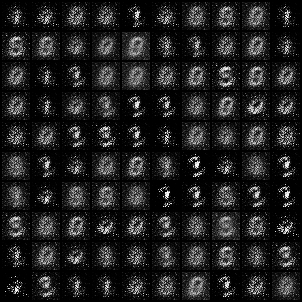

In [ ]:
Image('./samples/fake_images-0010.png')

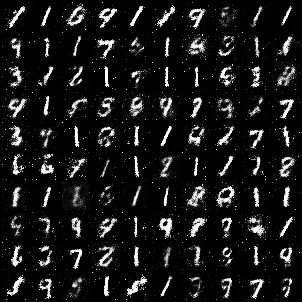

In [ ]:
Image('./samples/fake_images-0050.png')

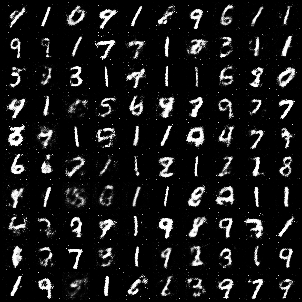

In [ ]:
Image('./samples/fake_images-0100.png')

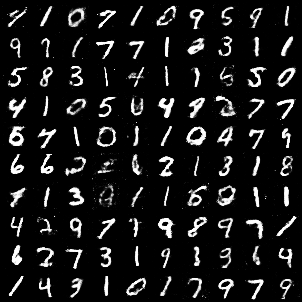

In [ ]:
Image('./samples/fake_images-0300.png')

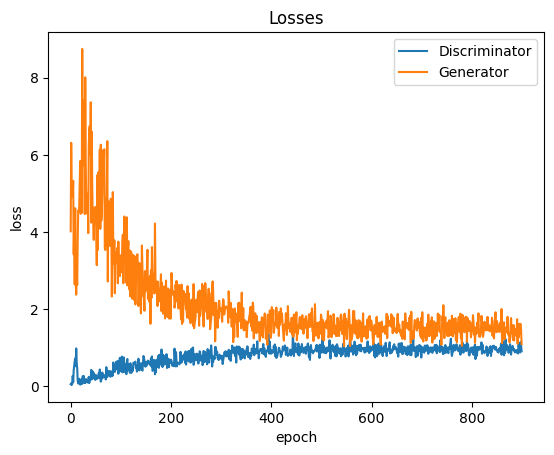

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

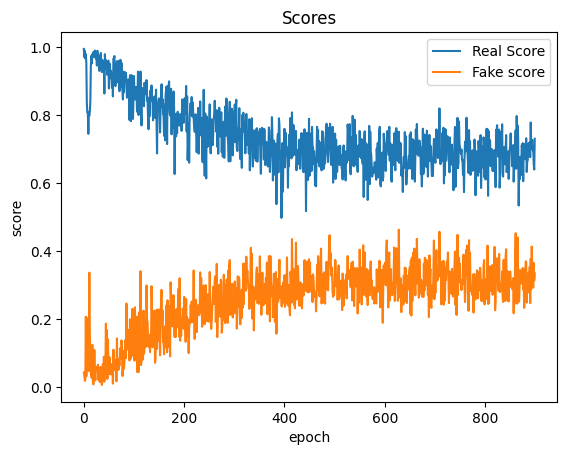

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Hello
